# Running a closed-loop adaptive optics system

In this tutorial we are going to look at simulating a closed-loop adaptive optics system. Our simulations will be based on the system designed for the Magallen Adaptive Optics Extreme (MagAO-X) system, that uses an unmodulated pyramid wavefront sensor with a 2k-MEMS DM. We first start by importing the relevant python modules.

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

# These modules are used for animating some of the graphs in our notebook.
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

We start by defining a few parameters according to the MagAO-X specifications. The Magallen telescope has a diameter of 6.5 meters, and we will use a sensing wavelength of 842nm. A zero magnitude star will have flux of 3.9E10 photons/s.

In [24]:
wavelength_wfs = 842.0E-9
telescope_diameter = 6.5
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0

The pyramid wavefront sensor design has a sampling of 56 pixels across the pupil with a distance of 60 pixels between the pupils. The final image size will be 120x120, which is the sampling of OCAM2K camera after 2x2 binning. To get the sampling correct it is the easiest to choose the pupil_grid_diameter as 60/56 larger than the actual telescope_diameter. On the created pupil grids we can evaluate the telescope aperture.

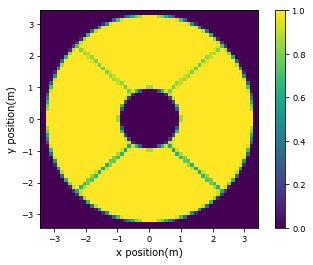

In [3]:
num_pupil_pixels = 60
pupil_grid_diameter = 60/56 * telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

magallen_aperture = evaluate_supersampled(make_magellan_aperture(), pupil_grid, 6)

imshow_field(magallen_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

Let's make our deformable mirror. MagAO-X uses a 2k-MEMS DM of Boston Micromachines. The influence functions of the DM are nearly gaussian. We will therefore make a DM with Gaussian influence functions. There are 50 actuators across the pupil.

In [4]:
num_act = 10
pitch = telescope_diameter / num_act
poke_centers = make_pupil_grid(num_act, telescope_diameter)
poke_centers = poke_centers.subset(poke_centers.as_('polar').r < telescope_diameter / 2)
dm_modes = make_gaussian_pokes(pupil_grid, poke_centers, pitch * np.sqrt(2))
num_modes = poke_centers.x.size

deformable_mirror = DeformableMirror(dm_modes)

Now we are going to make the optics of the pyramid wavefront sensor and the camera. Because the OCAM2K is a very high performance EMCCD we will simulate this detector as a noiseless detector.

In [5]:
pwfs = PyramidWavefrontSensorOptics(pupil_grid, wavelength_0=wavelength_wfs)
camera = NoiselessDetector()

We are going to use a linear reconstruction algorithm for the wavefront estimation and for that we will need to measure the reference response of a perfect incoming wavefront. To create this we create an unabberated wavefront and propagate it through the pyramid wavefront sensor. Then we will integrate the response with our camera.

The final reference will be divided by the total sum to normalize the wavefront sensor response. Doing this consequently for all exposures will make sure that we can use this reference for arbitrary exposure times and photon fluxes.

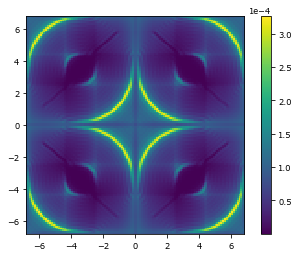

In [6]:
wf = Wavefront(magallen_aperture, wavelength_wfs)
wf.total_power = 1

camera.integrate( pwfs.forward(wf), 1)

image_ref = camera.read_out()
image_ref /= image_ref.sum()

imshow_field(image_ref)
plt.colorbar()
plt.show()

For the linear reconstructor we need to now the interaction matrix, which tells us how the pyramid wavefront sensor responds to each actuator of the deformable mirror. This can be build by sequentially applying a positive and negative voltage on a single acuator. The difference between the two gives us the actuator response.

In [7]:
# Create the interaction matrix
probe_amp = 0.01 * wavelength_wfs
slopes = []

wf = Wavefront(magallen_aperture, wavelength_wfs)
wf.total_power = 1

for ind in range(num_modes):
    if ind % 10 == 0:
        print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    slope = 0

    # Probe the phase response
    for s in [1, -1]:
        amp = np.zeros((num_modes,))
        amp[ind] = s * probe_amp
        deformable_mirror.actuators = amp

        dm_wf = deformable_mirror.forward(wf)
        wfs_wf = pwfs.forward(dm_wf)

        camera.integrate(wfs_wf, 1)
        image = camera.read_out()
        image /= np.sum(image)

        slope += s * (image-image_ref)/(2 * probe_amp)

    slopes.append(slope)

slopes = ModeBasis(slopes)

Measure response to mode 1 / 80
Measure response to mode 11 / 80
Measure response to mode 21 / 80
Measure response to mode 31 / 80
Measure response to mode 41 / 80
Measure response to mode 51 / 80
Measure response to mode 61 / 80
Measure response to mode 71 / 80


The matrix that we build by poking the actuators can be used to transform a DM pattern into the wavefront sensor response. For wavefront reconstruction we want to invert this. We currently have,
\begin{equation}
\vec{S} = A\vec{\phi}.
\end{equation}
With $\vec{S}$ being the response of the wavefront sensor, $A$ the interaction matrix and $\vec{\phi}$ the incoming pertubation on the DM. This equation can be solved in a linear least squares sense,
\begin{equation}
\vec{\phi} = \left(A^TA\right)^{-1} A^T\vec{S}.
\end{equation}
The matrix $\left(A^TA\right)^{-1} A^T$ can be found by applying a pseudo-inverse operation on the matrix $A$. A regularized version of this is implemented in HCIpy with the inverse_tikhonov function.

In [8]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)

The wavefront is then initialized with the Magallen aperture and the sensing wavelength. To have something to measure and correct we put a random shape on the DM.

In [17]:
wf_wfs = Wavefront(magallen_aperture, wavelength_wfs)
wf_wfs.total_power = zero_magnitude_flux * 10**(-stellar_magnitude/2.5)
print("Total photon flux {:g}".format(wf_wfs.total_power))

deformable_mirror.random(0.1 * wavelength_wfs)

Total photon flux 39000


Now lets setup the parameters of our AO system. The first step is to choose an integration time for the exposures. We choose an exposure time of 1 ms, so we are running our AO system at 1 kHz. For the controller we choose to use a leaky integrator which has been proven to be a robust controller. The leaky integrator has two paramets, the leakage and the gain.

In [18]:
delta_t = 1E-3
leakage = 0.01
gain = 0.5

Measure some statistics from the input wavefront so that we can later compare the improvement.

In [19]:
input_opd = deformable_mirror.opd
input_opd = magallen_aperture * (input_opd - np.mean(input_opd[magallen_aperture>0]))

input_phase_rms = 2 * np.pi / wavelength_wfs * np.std(input_opd[magallen_aperture>0])

spatial_resolution = wavelength_wfs / telescope_diameter
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

Inorm = propagator.forward( wf_wfs ).power.max()
PSF_in = propagator.forward( deformable_mirror.forward(wf_wfs) ).power / Inorm
input_strehl = PSF_in.max()


Now we are ready to run the system in closed loop. We will run for 10 iterations.

In [20]:
for i in range(10):
    wf_dm = deformable_mirror.forward(wf_wfs)
    wf_pyr = pwfs.forward(wf_dm)

    camera.integrate(wf_pyr, 1)
    wfs_image = large_poisson( camera.read_out() ).astype(np.float)
    wfs_image /= np.sum(wfs_image)

    diff_image = wfs_image-image_ref
    deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image)
    
PSF_out = propagator.forward( deformable_mirror.forward(wf_wfs) ).power/Inorm

Now we compare the input wavefront to the output wavefront. We can clearly see a large improvement in the quality of the wavefront.

Estimated Strehl input 0.130434 and output 0.977454


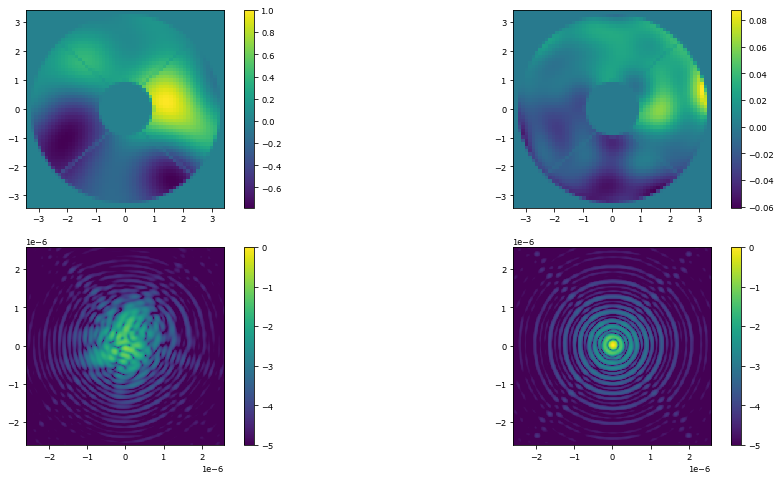

In [21]:
residual_opd = deformable_mirror.opd
residual_opd = magallen_aperture * (residual_opd - np.mean(residual_opd[magallen_aperture>0]))

phase_rms = 2 * np.pi / wavelength_wfs * np.std(residual_opd[magallen_aperture>0])
strehl = PSF_out.max()

print("Estimated Strehl input {:g} and output {:g}".format(input_strehl, strehl))

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
imshow_field(input_opd/wavelength_wfs)
plt.colorbar()

plt.subplot(2,2,2)
imshow_field(residual_opd/wavelength_wfs)
plt.colorbar()

plt.subplot(2,2,3)
imshow_field(np.log10(PSF_in), vmin=-5, vmax=0)
plt.colorbar()

plt.subplot(2,2,4)
imshow_field(np.log10(PSF_out), vmin=-5, vmax=0)
plt.colorbar()

plt.show()

And if we run for another 10 iterations the PSF close to perfect.

In [22]:
for i in range(10):
    wf_dm = deformable_mirror.forward(wf_wfs)
    wf_pyr = pwfs.forward(wf_dm)

    camera.integrate(wf_pyr, 1)
    wfs_image = large_poisson( camera.read_out() ).astype(np.float)
    wfs_image /= np.sum(wfs_image)

    diff_image = wfs_image-image_ref
    deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image)
    
PSF_out = propagator.forward( deformable_mirror.forward(wf_wfs) ).power/Inorm

Estimated Strehl input 0.130434 and output 0.999552


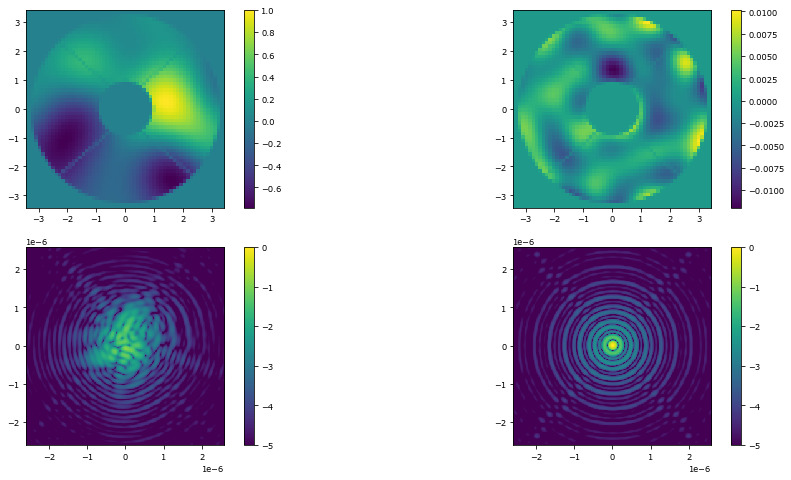

In [23]:
residual_opd = deformable_mirror.opd
residual_opd = magallen_aperture * (residual_opd - np.mean(residual_opd[magallen_aperture>0]))

phase_rms = 2 * np.pi / wavelength_wfs * np.std(residual_opd[magallen_aperture>0])
strehl = PSF_out.max()

print("Estimated Strehl input {:g} and output {:g}".format(input_strehl, strehl))

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
imshow_field(input_opd/wavelength_wfs)
plt.colorbar()

plt.subplot(2,2,2)
imshow_field(residual_opd/wavelength_wfs)
plt.colorbar()

plt.subplot(2,2,3)
imshow_field(np.log10(PSF_in), vmin=-5, vmax=0)
plt.colorbar()

plt.subplot(2,2,4)
imshow_field(np.log10(PSF_out), vmin=-5, vmax=0)
plt.colorbar()

plt.show()